In [24]:
# Initial imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_validate
from statistics import mean, mode

In [3]:
# Loading data
file_path = Path("../data/myopia.csv")
df = pd.read_csv(file_path)
df.head(5)

,AGE,SPHEQ,AL,ACD,LT,VCD,SPORTHR,READHR,COMPHR,STUDYHR,TVHR,DIOPTERHR,MOMMY,DADMY,MYOPIC
0,6,-0.052,21.889999,3.690,3.498,14.70,45,8,0,0,10,34,1,1,1
1,6,0.608,22.379999,3.702,3.392,15.29,4,0,1,1,7,12,1,1,0
2,6,1.179,22.490000,3.462,3.514,15.52,14,0,2,0,10,14,0,0,0
3,6,0.525,22.200001,3.862,3.612,14.73,18,11,0,0,4,37,0,1,1
4,5,0.697,23.290001,3.676,3.454,16.16,14,0,0,0,4,4,1,0,0


In [4]:
# Check dataset balance
df["MYOPIC"].value_counts()

0    537
1     81
Name: MYOPIC, dtype: int64

In [5]:
# Check dataset balance
df["MYOPIC"].value_counts(normalize=True)

0    0.868932
1    0.131068
Name: MYOPIC, dtype: float64

In [6]:
# Define X,y
label = df["MYOPIC"]
X = df.iloc[:,:-1].copy()
X.head()

,AGE,SPHEQ,AL,ACD,LT,VCD,SPORTHR,READHR,COMPHR,STUDYHR,TVHR,DIOPTERHR,MOMMY,DADMY
0,6,-0.052,21.889999,3.690,3.498,14.70,45,8,0,0,10,34,1,1
1,6,0.608,22.379999,3.702,3.392,15.29,4,0,1,1,7,12,1,1
2,6,1.179,22.490000,3.462,3.514,15.52,14,0,2,0,10,14,0,0
3,6,0.525,22.200001,3.862,3.612,14.73,18,11,0,0,4,37,0,1
4,5,0.697,23.290001,3.676,3.454,16.16,14,0,0,0,4,4,1,0


## KNN

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, label, random_state=42)

In [8]:
# Create a scaler to standardize the data
scaler = StandardScaler()

In [11]:
# Train the scaler with the X_train data.
scaler.fit(X_train)

StandardScaler()

In [12]:
# Transform X_train and X_test.
# Note that the scaler used to transform X_train and X_test was trained on X_train.
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Determine best k value

k: 1, Train/Test Score: 1.000/0.774
k: 3, Train/Test Score: 0.892/0.839
k: 5, Train/Test Score: 0.879/0.865
k: 7, Train/Test Score: 0.879/0.865
k: 9, Train/Test Score: 0.888/0.871
k: 11, Train/Test Score: 0.881/0.877
k: 13, Train/Test Score: 0.877/0.877
k: 15, Train/Test Score: 0.877/0.871
k: 17, Train/Test Score: 0.873/0.871
k: 19, Train/Test Score: 0.875/0.871


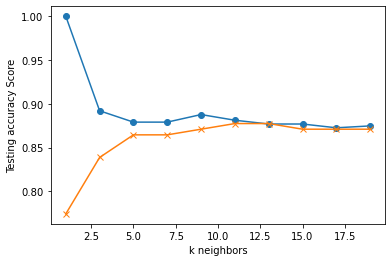

In [13]:
# Loop through different k values to find which has the highest accuracy.
# Note: We use only odd numbers because we don't want any ties.
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

## Run best k value model

In [14]:
# Instantiate KNN model and make predictions
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.864516129032258

In [15]:
confusion_matrix(y_test, y_pred)

array([[134,   3],
       [ 18,   0]], dtype=int64)

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       137
           1       0.00      0.00      0.00        18

    accuracy                           0.86       155
   macro avg       0.44      0.49      0.46       155
weighted avg       0.78      0.86      0.82       155



In [26]:
scoring = ('f1', 'recall', 'precision', 'roc_auc')
steps = [('scaler', StandardScaler()), ('model', KNeighborsClassifier(n_neighbors=5))]
pipeline = Pipeline(steps=steps)

# evaluate pipeline
# Note for imbalanced classification don't use k-fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))
print('Mean ROC AUC: %.3f' % mean(scores['test_roc_auc']))
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f"-----"*10)
print(classification_report(y_test, y_pred))

Mean f1: 0.193
Mean recall: 0.144
Mean precision: 0.349
Mean ROC AUC: 0.643
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       137
           1       0.00      0.00      0.00        18

    accuracy                           0.86       155
   macro avg       0.44      0.49      0.46       155
weighted avg       0.78      0.86      0.82       155



### Reality Check
Predicting all patients to not have myopia results in 87% accuracy
which is the same as the model result

TN is high but TP is zero.  So it predicted the True negatives but none of the True positives (predicted nothing correct).  

Most of the errors were predicting False Positives, where 18 preductions were assigned as true when they were actually false.   

The key take-away is that there were only 2 positive cases to predict, which is insuficient.   

## KNN with Balanced Data

In [17]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [18]:
ros = RandomOverSampler(random_state=42)
x_ros, y_ros = ros.fit_resample(X_train, y_train)

In [19]:
print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_ros))

Original dataset shape Counter({0: 400, 1: 63})
Resample dataset shape Counter({0: 400, 1: 400})


In [20]:
# Create a scaler to standardize the data
scaler = StandardScaler()

# Train the scaler with the X_train data.
scaler.fit(x_ros)

# Transform X_train and X_test.
# Note that the scaler used to transform X_train and X_test was trained on X_train.
X_ros_train_scaled = scaler.transform(x_ros)
X_test_scaled = scaler.transform(X_test)

## Test for best k

k: 1, Train/Test Score: 1.000/0.781
k: 3, Train/Test Score: 0.935/0.735
k: 5, Train/Test Score: 0.882/0.742
k: 7, Train/Test Score: 0.838/0.761
k: 9, Train/Test Score: 0.805/0.716
k: 11, Train/Test Score: 0.812/0.703
k: 13, Train/Test Score: 0.787/0.690
k: 15, Train/Test Score: 0.786/0.703
k: 17, Train/Test Score: 0.779/0.690
k: 19, Train/Test Score: 0.776/0.684


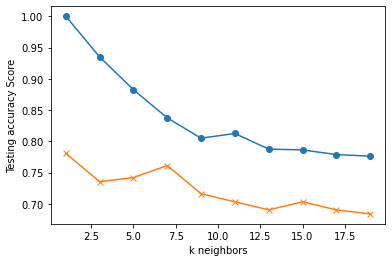

In [21]:
# Loop through different k values to find which has the highest accuracy.
# Note: We use only odd numbers because we don't want any ties.
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_ros_train_scaled, y_ros)
    train_score = knn.score(X_ros_train_scaled, y_ros)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [22]:
# Instantiate KNN model and make predictions
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_ros_train_scaled, y_ros)
y_pred = knn.predict(X_test_scaled)
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
print(f"Confusion matrix:  {confusion_matrix(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy score: 0.7612903225806451
Confusion matrix:  [[110  27]
 [ 10   8]]
              precision    recall  f1-score   support

           0       0.92      0.80      0.86       137
           1       0.23      0.44      0.30        18

    accuracy                           0.76       155
   macro avg       0.57      0.62      0.58       155
weighted avg       0.84      0.76      0.79       155



In [27]:
scoring = ('f1', 'recall', 'precision', 'roc_auc')
steps = [('scaler', StandardScaler()), ('over', RandomOverSampler(random_state=42)), ('model', KNeighborsClassifier(n_neighbors=7))]
pipeline = Pipeline(steps=steps)

# evaluate pipeline
# Note for imbalanced classification don't use k-fold cross-validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))
print('Mean ROC AUC: %.3f' % mean(scores['test_roc_auc']))
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f"-----"*10)
print(classification_report(y_test, y_pred))

Mean f1: 0.292
Mean recall: 0.590
Mean precision: 0.195
Mean ROC AUC: 0.656
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       137
           1       0.25      0.56      0.34        18

    accuracy                           0.75       155
   macro avg       0.59      0.67      0.60       155
weighted avg       0.85      0.75      0.79       155



## Analysis
This example shows 8 True Positives but this only accounts for 23% of the potential cases (8/35).